## Solve Biaxial Strain

In [43]:
using LinearAlgebra

#initializing the value of tensor a
a0 = 1/3 * I(3)

ϕ = 0.56
β = 5
ϵ_dot = 0.5 #strain rate
#gradient of velocity L
L = [ϵ_dot 0.0 0.0;
     0.0 ϵ_dot 0.0;
     0.0 0.0 -2*ϵ_dot]

E = 0.5 * (L + transpose(L))

function split_E(E::AbstractMatrix)
    λ, Q = eigen(E)  # spectral decomposition

    Λ_c = Diagonal([min(λ[i], 0.0) for i in 1:3])
    Λ_e = Diagonal(λ) - Λ_c

    E_c = Q * Λ_c * Q'
    E_e = Q * Λ_e * Q'
    return E_c, E_e
end

E_c, E_e = split_E(E)
println(E_c)
println(E_e)

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 -1.0]
[0.5 0.0 0.0; 0.0 0.5 0.0; 0.0 0.0 0.0]


In [44]:
println(L)

[0.5 0.0 0.0; 0.0 0.5 0.0; 0.0 0.0 -1.0]


In [45]:
#define Kronecker Delta Function δ(i,j)
δ(i,j) = i == j ? 1.0 : 0.0

#define the four-rank tensor b in terms of a (linear Closure)
function compute_b(a::AbstractMatrix)
    b = zeros(Float64, 3, 3, 3, 3)
    tr_a = tr(a)

    for i in 1:3, j in 1:3, k in 1:3, l in 1:3
        b[i,j,k,l] = -(1/35)*tr_a*(δ(i,j)*δ(k,l) + δ(i,k)*δ(j,l) + δ(i,l)*δ(j,k)) +
                      (1/7)*(δ(i,j)*a[k,l] + δ(i,k)*a[j,l] + δ(i,l)*a[j,k] +
                             δ(j,k)*a[i,l] + δ(j,l)*a[i,k] + δ(k,l)*a[i,j])
    end
    return b
end




compute_b (generic function with 1 method)

In [46]:
#calculate the tensor product L:b
function contract_L_b(L::AbstractMatrix, b::Array{Float64,4})
    result = zeros(3,3)
    for i in 1:3, j in 1:3
        for k in 1:3, l in 1:3
            result[k,l] += L[i,j] * b[i,j,k,l]
        end
    end
    return result
end

#calculate the tensor product E_e:b
function contract_Ee_b(Ee::AbstractMatrix, b::Array{Float64,4})
    result = zeros(3,3)
    for i in 1:3, j in 1:3
        for k in 1:3, l in 1:3
            result[k,l] += Ee[i,j] * b[i,j,k,l]
        end
    end
    return result
end


#compute the right hand side of the differential equation (this is a matrix)
function compute_rhs(a, L, E_c, E_e, ϕ, β)
    b = compute_b(a)      #generate b dynamically from a
    term1 = L * a + a * transpose(L)
    term2 = -2 * contract_L_b(L, b)
    term3 = -β * (contract_Ee_b(E_e, b) + (ϕ/15.0)*(2*E_c + tr(E_c)*I))
    return term1 + term2 + term3
end

compute_rhs (generic function with 1 method)

In [47]:
using DifferentialEquations


In [48]:
function rhs!(du, u, p, t)
    # reshape u back into a matrix a
    a = reshape(u, 3, 3)

    L, E_c, E_e, ϕ, β = p
    rhs_matrix = compute_rhs(a, L, E_c, E_e, ϕ, β)
    
    du .= vec(rhs_matrix)  # flatten back to vector, because rhs_matrix is a matrix
end

rhs! (generic function with 1 method)

In [49]:
#set the initial conditions
a0 = (1/3) * I(3)
u0 = vec(a0)  # flatten to 9-element vector
tspan = (0.0, 5.0)
params = (L, E_c, E_e, ϕ, β)

prob = ODEProblem(rhs!, u0, tspan, params)

sol = solve(prob, TRBDF2(autodiff=false), dt=1e-3, abstol=1e-8, reltol=1e-6)

a_list = [reshape(u, 3, 3) for u in sol.u]


39-element Vector{Matrix{Float64}}:
 [0.3333333333333333 0.0 0.0; 0.0 0.3333333333333333 0.0; 0.0 0.0 0.3333333333333333]
 [0.33305356272706654 0.0 0.0; 0.0 0.33305356272706654 0.0; 0.0 0.0 0.3331602407374204]
 [0.3302809415355825 0.0 0.0; 0.0 0.3302809415355825 0.0; 0.0 0.0 0.33145555137749283]
 [0.3220396289336233 0.0 0.0; 0.0 0.3220396289336233 0.0; 0.0 0.0 0.3265057782803224]
 [0.31647429555209 0.0 0.0; 0.0 0.31647429555209 0.0; 0.0 0.0 0.3232667760113172]
 [0.3018307003646201 0.0 0.0; 0.0 0.3018307003646201 0.0; 0.0 0.0 0.315164192353457]
 [0.29491821653795264 0.0 0.0; 0.0 0.29491821653795264 0.0; 0.0 0.0 0.3115696861968932]
 [0.2764063034878478 0.0 0.0; 0.0 0.2764063034878478 0.0; 0.0 0.0 0.3027374203243814]
 [0.2699459366619471 0.0 0.0; 0.0 0.2699459366619471 0.0; 0.0 0.0 0.29996618936565034]
 [0.2567808332871527 0.0 0.0; 0.0 0.2567808332871527 0.0; 0.0 0.0 0.2948762942589261]
 [0.25052540448111915 0.0 0.0; 0.0 0.25052540448111915 0.0; 0.0 0.0 0.292757696274227]
 [0.239024628892

In [50]:
#define double contraction of two-rank tensors
function double_contract(A::AbstractMatrix, B::AbstractMatrix)
    return sum(A .* B)
end


double_contract (generic function with 1 method)

In [51]:
# define the parameters that participated into the iterations
ϕ = 0.56
ϕ1_J = 0.644
ϕ2_J = 0.578
ξ1_J = 0.88
ξ2_J = 0.78
α_0 = 2.3
χ_0 = 2.4
β_0 = 6.9
μ = 1.0
Π_star = 5 # for simplicity



5

In [52]:
#define how to multiply a two-rank tensor A by a four-rank tensor b
function tensor_contraction(A::AbstractMatrix, b::Array{Float64,4})
    Σ = zeros(3, 3)
    for i in 1:3, j in 1:3, k in 1:3, l in 1:3
        Σ[k, l] += A[i, j] * b[i, j, k, l]
    end
    return Σ
end

#now explicitly define the calculation of Σ
function compute_sigma_tensor(E, E_c, b, ϕ, ϕ_J, ξ, ξ_J, α_0, χ_0, μ)
    A = (α_0 * E) / (1 - ϕ/ϕ_J)^2 + (χ_0 * E_c) / (1 - ξ/ξ_J)^2
    Σ = μ * tensor_contraction(A, b)
    return Σ
end



Sigma_list = []
f_list = []
for u in sol.u
    a_t = reshape(u, 3, 3)
    b_t = compute_b(a_t)
    #dynamically update ξ in each time step    
    norm_Ec = sqrt(double_contract(E_c, E_c))
    ξ = -double_contract(a_t, E_c)/norm_Ec
    
    tol=1e-6
    maxiter=50
    Σ = nothing  #initializing the global variable but with no value
    f = 0.5
    
    for iter in 1:maxiter
        ϕ_J = ϕ1_J * (1 - f) + ϕ2_J * f
        ξ_J = ξ1_J * (1 - f) + ξ2_J * f
        ϕ = 0.56
        Σ = compute_sigma_tensor(E, E_c, b_t, ϕ, ϕ_J, ξ, ξ_J, α_0, χ_0, μ)
        Π = -tr(Σ)/3
        f_new = exp(-Π_star / Π)

        if abs(f_new - f) < tol
            break
        end
    
        f = f_new
    end
    push!(Sigma_list, Σ)
    push!(f_list, f)
    
end

println(Sigma_list)
println(f_list)

Any[[8.606830753281544 0.0 0.0; 0.0 8.606830753281544 0.0; 0.0 0.0 -19.286920505399188], [8.597697748337438 0.0 0.0; 0.0 8.597697748337438 0.0; 0.0 0.0 -19.28071148734979], [8.507541230190375 0.0 0.0; 0.0 8.507541230190375 0.0; 0.0 0.0 -19.22171781565025], [8.245593537468467 0.0 0.0; 0.0 8.245593537468467 0.0; 0.0 0.0 -19.07908811127981], [8.076327693690525 0.0 0.0; 0.0 8.076327693690525 0.0; 0.0 0.0 -19.017403159535874], [7.6773041172414125 0.0 0.0; 0.0 7.6773041172414125 0.0; 0.0 0.0 -19.04000678688042], [7.520329126394774 0.0 0.0; 0.0 7.520329126394774 0.0; 0.0 0.0 -19.174031857680934], [7.243630505847634 0.0 0.0; 0.0 7.243630505847634 0.0; 0.0 0.0 -20.116996439152896], [7.215480403028222 0.0 0.0; 0.0 7.215480403028222 0.0; 0.0 0.0 -20.73841131625404], [7.337058967935695 0.0 0.0; 0.0 7.337058967935695 0.0; 0.0 0.0 -22.802057787078212], [7.527711625956211 0.0 0.0; 0.0 7.527711625956211 0.0; 0.0 0.0 -24.385644015259423], [8.330746327598167 0.0 0.0; 0.0 8.330746327598167 0.0; 0.0 0.0 -

In [53]:
Sigma_final = Sigma_list[end]
println(Sigma_final)

[23.513142196944116 0.0 0.0; 0.0 23.513142196944116 0.0; 0.0 0.0 -216.0373773995641]


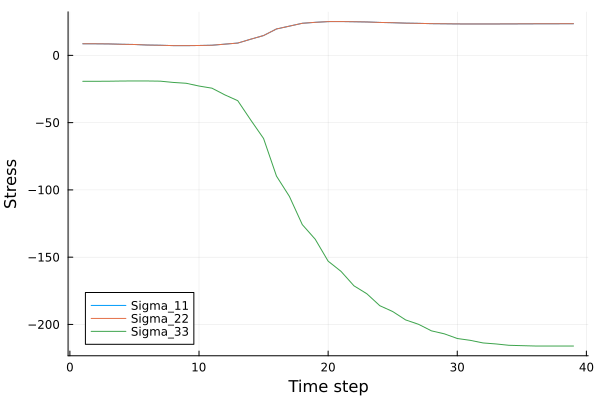

In [54]:
using Plots
plot([Σ[1,1] for Σ in Sigma_list], label="Sigma_11", xlabel="Time step", ylabel="Stress")
plot!([Σ[2,2] for Σ in Sigma_list], label="Sigma_22")
plot!([Σ[3,3] for Σ in Sigma_list], label="Sigma_33")

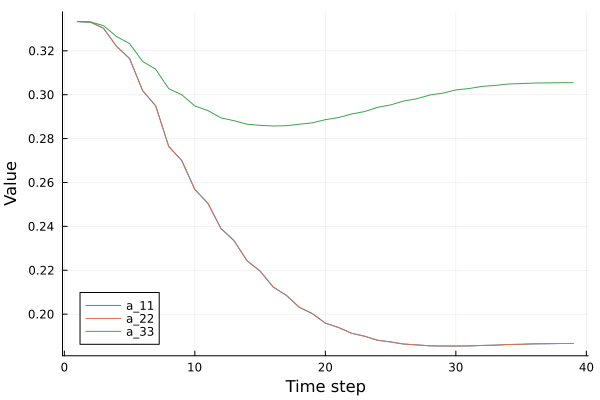

In [55]:
a_11 = [a[1,1] for a in a_list]
a_22 = [a[2,2] for a in a_list]
a_33 = [a[3,3] for a in a_list]
plot(a_11, label="a_11", xlabel="Time step", ylabel="Value")
plot!(a_22, label="a_22")
plot!(a_33, label="a_33")

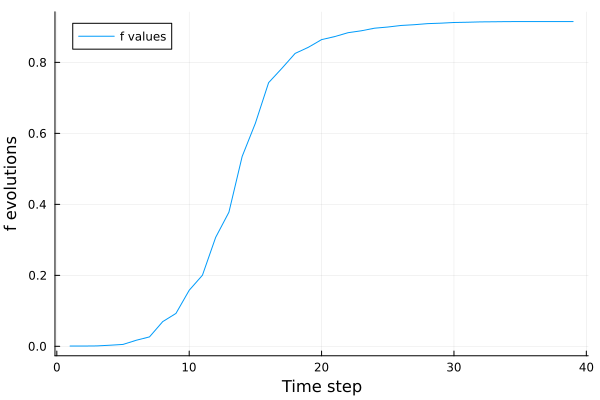

In [56]:
plot(f_list, label = "f values", xlabel = "Time step", ylabel = "f evolutions")

## See how change in $\phi$ affects components in a and $\Sigma$ in their steady states

In [85]:
#encode the computation of a_final and Sigma_final into a function, convenient for subsequent plottings
function run_simulation_phi(ϕ; β=5.0, ϕ1_J = 0.644, ϕ2_J = 0.578, ξ1_J = 0.88, ξ2_J = 0.78, α_0 = 2.3, χ_0 = 2.4, β_0 = 6.9, μ = 1.0, Π_star = 5)
    a_old = (1/3) * I(3)
    u_old = reshape(a_old, 9)
    dt = 0.10
    t_span = (0.0, dt)
    tolerance=1e-10
    max_run_time=200

    #solve the ode in small time scale several times, rather than over a long period of time
    for iter in 1:max_run_time
        params = (L, E_c, E_e, ϕ, β)
        prob = ODEProblem(rhs!, u_old, tspan, params)
        sol = solve(prob, TRBDF2(autodiff=false), abstol=1e-8, reltol=1e-6)
        a_new = reshape(sol.u[end], 3, 3)

        a_new = 0.5 * (a_new + transpose(a_new))  # enforce symmetry
        a_new ./= tr(a_new)                      # make trace = 1

        if norm(a_new - a_old) < tolerance  #this ensures that a converges to the steady state
            a_old = a_new
            break
        end

        a_old = a_new
        u_old = reshape(a_old, 9)
    end

    
    a_final = a_old ./ tr(a_old)  
    b_final = compute_b(a_final)

    #compute ξ according to a_final
    norm_Ec = sqrt(double_contract(E_c, E_c))
    ξ = -double_contract(a_final, E_c)/norm_Ec
    
    tol=1e-6
    maxiter=100
    Σ = nothing  #initializing the global variable but with no value
    f = 0.5
    
    for iter in 1:maxiter
        ϕ_J = ϕ1_J * (1 - f) + ϕ2_J * f
        ξ_J = ξ1_J * (1 - f) + ξ2_J * f

        Σ = compute_sigma_tensor(E, E_c, b_final, ϕ, ϕ_J, ξ, ξ_J, α_0, χ_0, μ)
        Π = -tr(Σ)/3
        f_new = exp(-Π_star/Π)

        if abs(f_new - f) < tol
            break
        end
    
        f = f_new
    end

    return a_final, Σ, f

end



run_simulation_phi (generic function with 1 method)

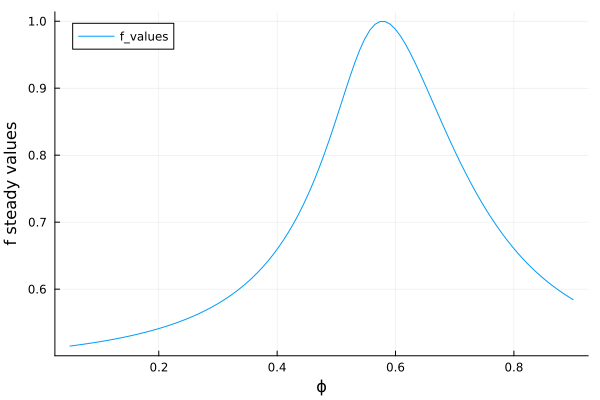

In [86]:
using Plots

phi_values = range(0.05, 0.90, length=100)

a11_list = []
a22_list = []
a33_list = []
Sigma11_list = []
Sigma22_list = []
Sigma33_list = []
f_list = []

for phi in phi_values
    x, y, z = run_simulation_phi(phi)
    push!(a11_list, x[1, 1])
    push!(a22_list, x[2, 2])
    push!(a33_list, x[3, 3])
    push!(Sigma11_list, y[1, 1])
    push!(Sigma22_list, y[2, 2])
    push!(Sigma33_list, y[3, 3])
    push!(f_list, z)
end

# Step 4: 绘图
plot(phi_values, f_list, label="f_values", xlabel="ϕ", ylabel="f steady values", legend=:topleft)



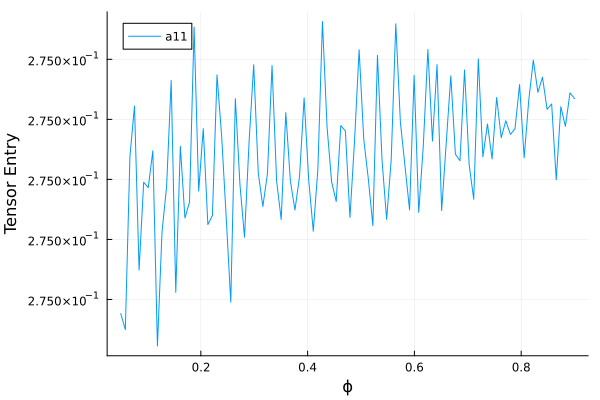

In [87]:
plot(phi_values, a11_list, label="a11", xlabel="ϕ", ylabel="Tensor Entry", legend=:topleft)

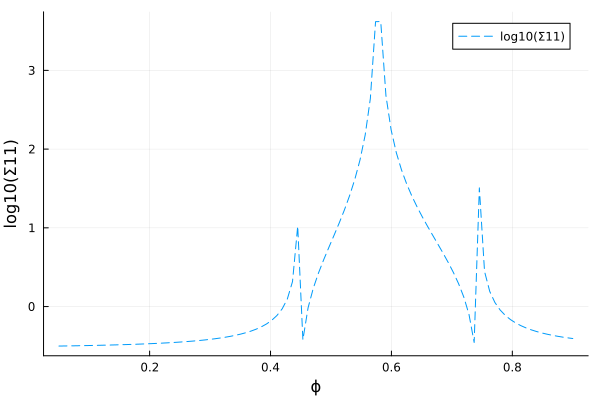

In [88]:
signed_log10(x) = x == 0 ? 0 : sign(x) * log10(abs(x))


plot(phi_values,
     [signed_log10(Σ) for Σ in Sigma11_list],
     label = "log10(Σ11)",
     xlabel = "ϕ",
     ylabel = "log10(Σ11)",
     linestyle = :dash)


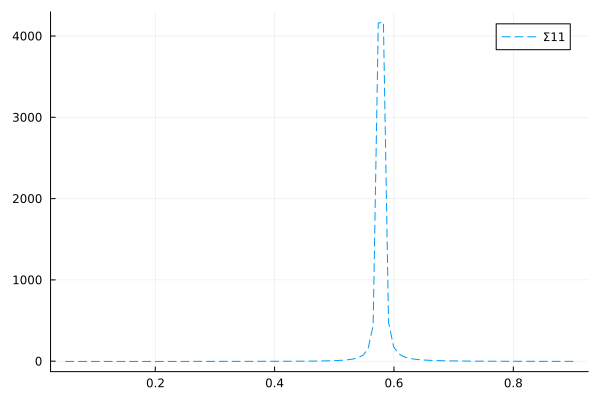

In [89]:
plot(phi_values, Sigma11_list, label="Σ11", linestyle=:dash)

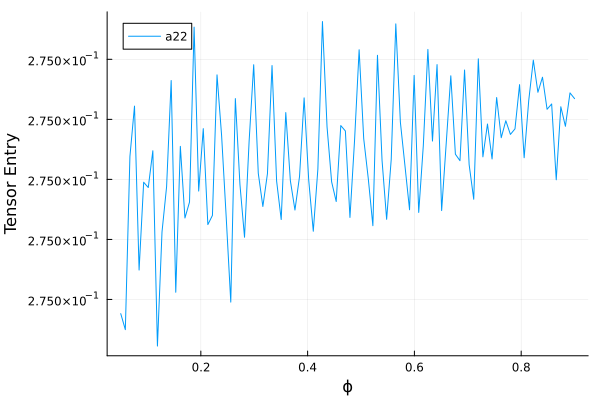

In [90]:
plot(phi_values, a22_list, label="a22", xlabel="ϕ", ylabel="Tensor Entry", legend=:topleft)

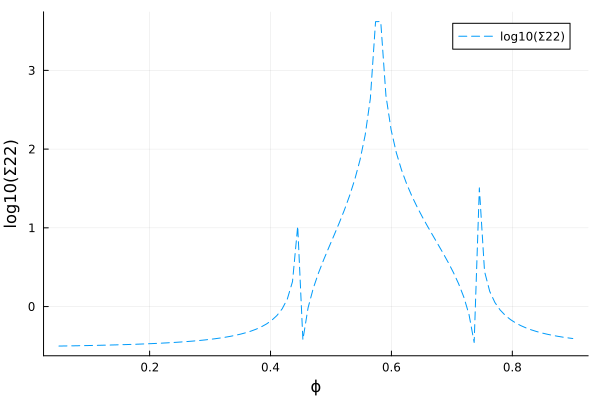

In [91]:
signed_log10(x) = x == 0 ? 0 : sign(x) * log10(abs(x))


plot(phi_values,
     [signed_log10(Σ) for Σ in Sigma22_list],
     label = "log10(Σ22)",
     xlabel = "ϕ",
     ylabel = "log10(Σ22)",
     linestyle = :dash)

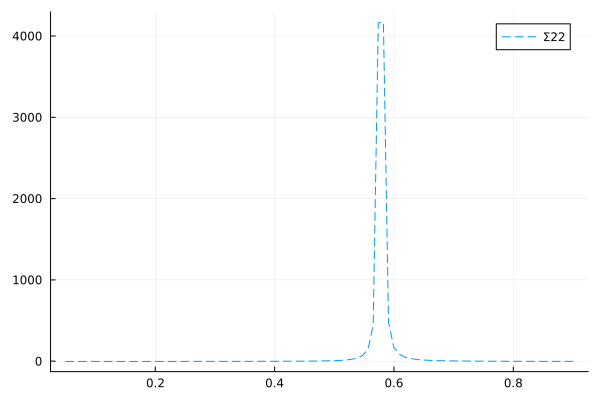

In [92]:
plot(phi_values, Sigma22_list, label="Σ22", linestyle=:dash)

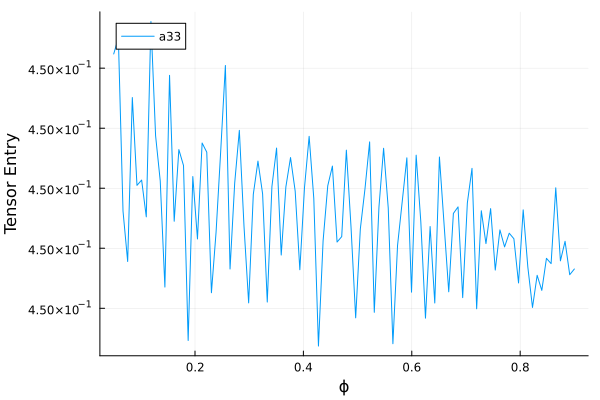

In [93]:
plot(phi_values, a33_list, label="a33", xlabel="ϕ", ylabel="Tensor Entry", legend=:topleft)

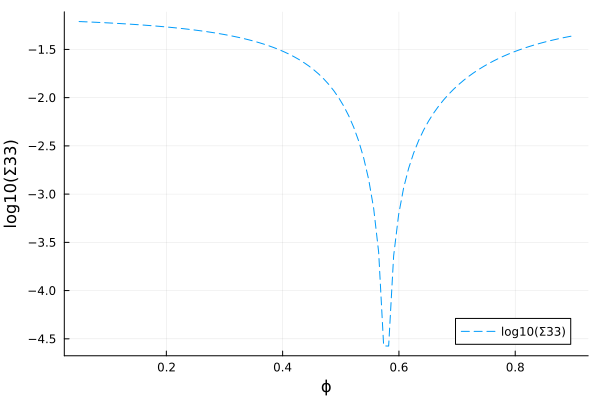

In [94]:
signed_log10(x) = x == 0 ? 0 : sign(x) * log10(abs(x))


plot(phi_values,
     [signed_log10(Σ) for Σ in Sigma33_list],
     label = "log10(Σ33)",
     xlabel = "ϕ",
     ylabel = "log10(Σ33)",
     linestyle = :dash)

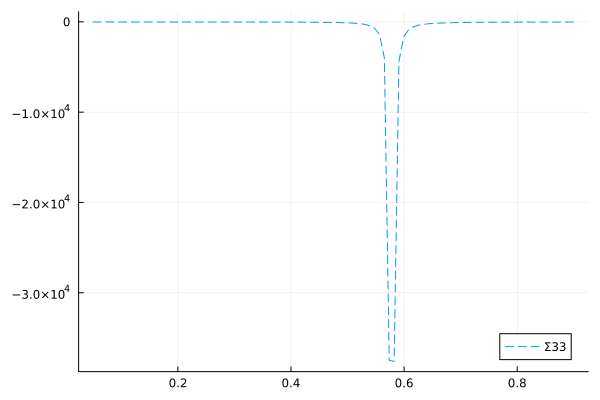

In [95]:
plot(phi_values, Sigma33_list, label="Σ33", linestyle=:dash)

## See how steady states of a and $\Sigma$ change with respect to $\beta$

In [96]:
#encode the computation of a_final and Sigma_final into a function, convenient for subsequent plottings
function run_simulation_beta(β; ϕ=0.56, ϕ1_J = 0.644, ϕ2_J = 0.578, ξ1_J = 0.88, ξ2_J = 0.78, α_0 = 2.3, χ_0 = 2.4, β_0 = 6.9, μ = 1.0, Π_star = 5)
    a_old = (1/3) * I(3)
    u_old = reshape(a_old, 9)
    dt = 0.10
    t_span = (0.0, dt)
    tolerance=1e-10
    max_run_time=200

    #solve the ode in small time scale several times, rather than over a long period of time
    for iter in 1:max_run_time
        params = (L, E_c, E_e, ϕ, β)
        prob = ODEProblem(rhs!, u_old, tspan, params)
        sol = solve(prob, TRBDF2(autodiff=false), abstol=1e-8, reltol=1e-6)
        a_new = reshape(sol.u[end], 3, 3)

        a_new = 0.5 * (a_new + transpose(a_new))  # enforce symmetry
        a_new ./= tr(a_new)                      # make trace = 1

        if norm(a_new - a_old) < tolerance  #this ensures that a converges to the steady state
            a_old = a_new
            break
        end

        a_old = a_new
        u_old = reshape(a_old, 9)
    end

    
    a_final = a_old
    b_final = compute_b(a_old)

    #compute ξ according to a_final dynamically, this is not a fixed parameter
    norm_Ec = sqrt(double_contract(E_c, E_c))
    ξ = -double_contract(a_final, E_c)/norm_Ec
    
    tol=1e-6
    maxiter=100
    Σ = nothing  #initializing the global variable but with no value
    f = 0.5
    
    for iter in 1:maxiter
        ϕ_J = ϕ1_J * (1 - f) + ϕ2_J * f
        ξ_J = ξ1_J * (1 - f) + ξ2_J * f

        Σ = compute_sigma_tensor(E, E_c, b_final, ϕ, ϕ_J, ξ, ξ_J, α_0, χ_0, μ)
        Π = -tr(Σ)/3
        f_new = exp(-Π_star/Π)

        if abs(f_new - f) < tol
            break
        end
    
        f = f_new
    end

    return a_final, Σ
end



run_simulation_beta (generic function with 1 method)

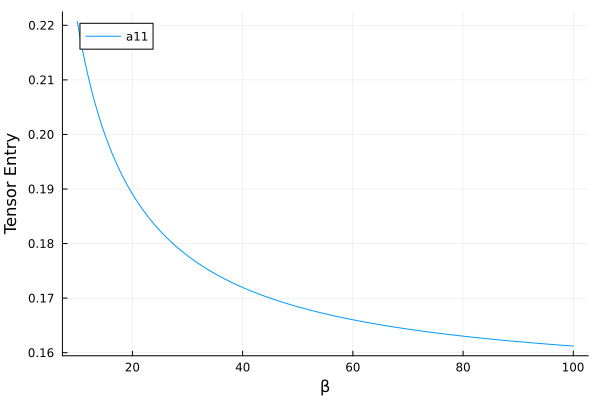

In [97]:
using Plots

beta_values = range(10.0, 100.0, length=200)

a11_list = []
a22_list = []
a33_list = []
Sigma11_list = []
Sigma22_list = []
Sigma33_list = []

for beta in beta_values
    x, y = run_simulation_beta(beta)
    push!(a11_list, x[1, 1])
    push!(a22_list, x[2, 2])
    push!(a33_list, x[3, 3])
    push!(Sigma11_list, y[1, 1])
    push!(Sigma22_list, y[2, 2])
    push!(Sigma33_list, y[3, 3])
end

# Step 4: 绘图
plot(beta_values, a11_list, label="a11", xlabel="β", ylabel="Tensor Entry", legend=:topleft)

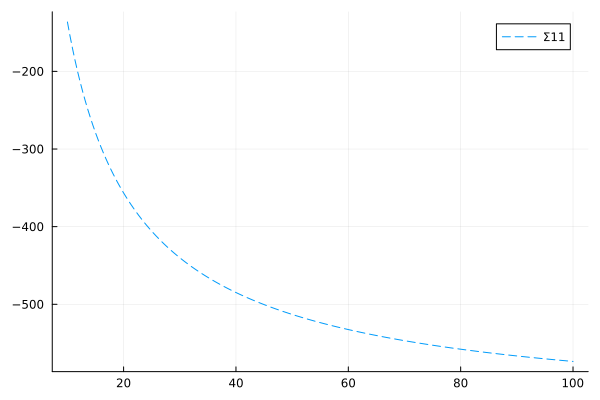

In [98]:
plot(beta_values, Sigma11_list, label="Σ11", linestyle=:dash)

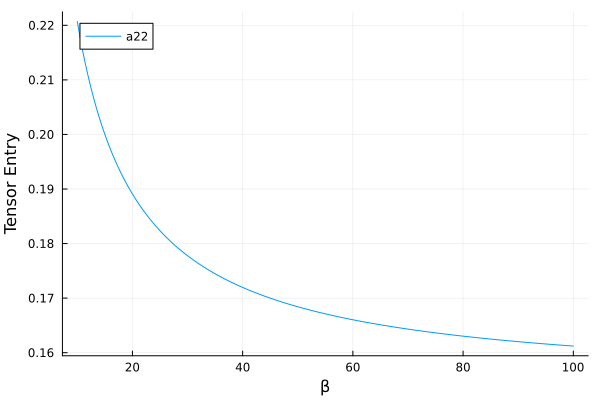

In [99]:
plot(beta_values, a22_list, label="a22", xlabel="β", ylabel="Tensor Entry", legend=:topleft)

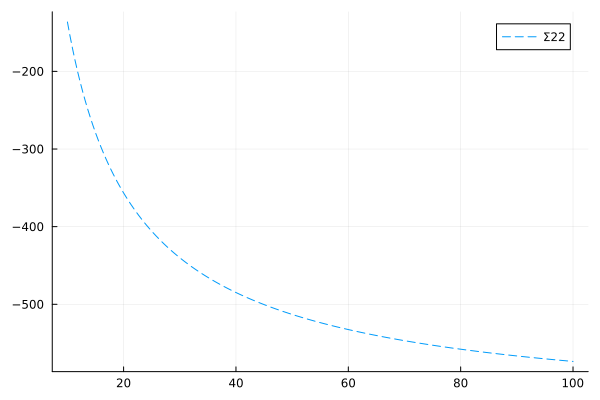

In [100]:
plot(beta_values, Sigma22_list, label="Σ22", linestyle=:dash)

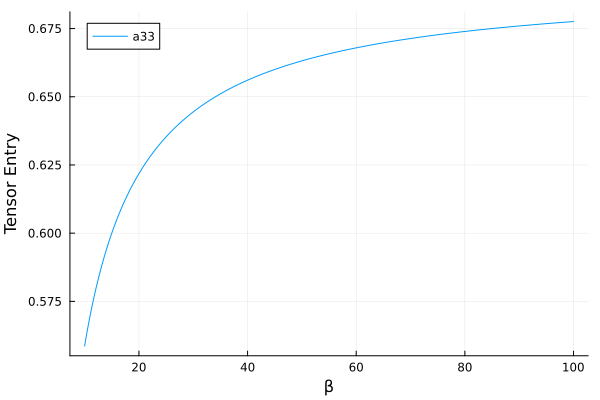

In [101]:
plot(beta_values, a33_list, label="a33", xlabel="β", ylabel="Tensor Entry", legend=:topleft)

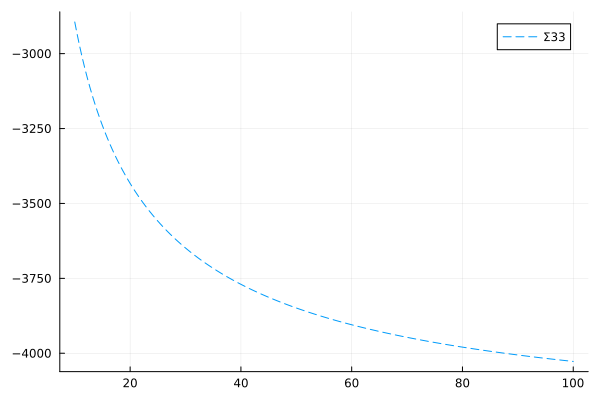

In [102]:
plot(beta_values, Sigma33_list, label="Σ33", linestyle=:dash)

## See how change in shear rate $\epsilon$_dot affects stress tensor $\Sigma$ (Shear Thickening Effect)

In [105]:
epsilon_dot_list = [0.01, 0.03, 0.05, 0.1, 0.13, 0.15, 0.2, 0.3, 0.4, 0.5, 0.53, 0.55, 0.6, 0.65, 0.7, 0.75, 0.78, 0.8, 1.0, 1.3, 1.5, 2.0]
Sigma11_list = []
Sigma22_list = []
Sigma33_list = []
f_list = []
for ϵ_dot in epsilon_dot_list
    L = [ϵ_dot 0.0 0.0;
         0.0 ϵ_dot 0.0;
         0.0 0.0 -2*ϵ_dot]

    E = 0.5 * (L + transpose(L))

    function split_E(E::AbstractMatrix)
        λ, Q = eigen(E)  # spectral decomposition

        Λ_c = Diagonal([min(λ[i], 0.0) for i in 1:3])
        Λ_e = Diagonal(λ) - Λ_c

        E_c = Q * Λ_c * Q'
        E_e = Q * Λ_e * Q'
        return E_c, E_e
    end

    E_c, E_e = split_E(E)

    a, Σ, f = run_simulation_phi(0.56)

    push!(Sigma11_list, Σ[1, 1])
    push!(Sigma22_list, Σ[2, 2])
    push!(Sigma33_list, Σ[3, 3])
    push!(f_list, f)
end
    

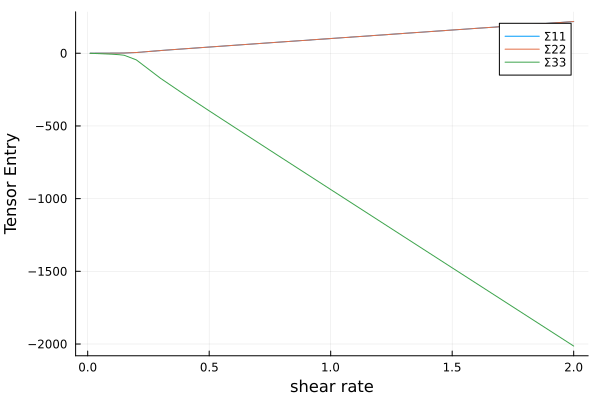

In [106]:
plot(epsilon_dot_list, Sigma11_list, label="Σ11", xlabel="shear rate", ylabel="Tensor Entry", legend=:topright)
plot!(epsilon_dot_list, Sigma22_list, label="Σ22", legend=:topright)
plot!(epsilon_dot_list, Sigma33_list, label="Σ33", legend=:topright)

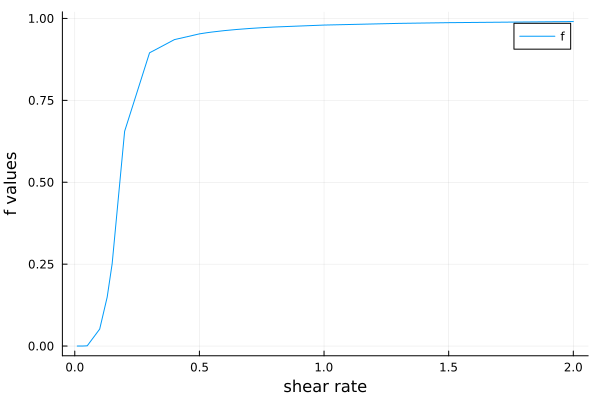

In [108]:
plot(epsilon_dot_list, f_list, label="f", xlabel="shear rate", ylabel="f values", legend=:topright)

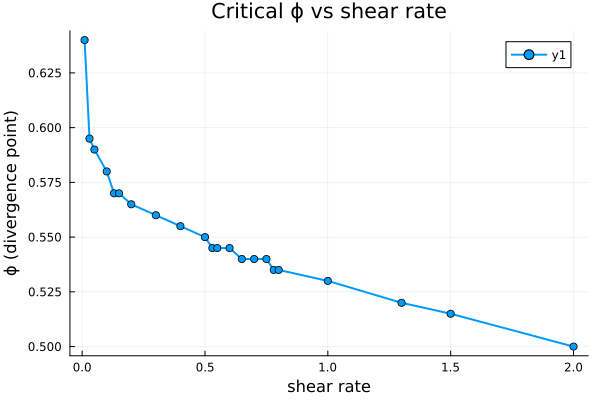

In [107]:
epsilon_dot_list = [0.01, 0.03, 0.05, 0.1, 0.13, 0.15, 0.2, 0.3, 0.4, 0.5, 0.53, 0.55, 0.6, 0.65, 0.7, 0.75, 0.78, 0.8, 1.0, 1.3, 1.5, 2.0]
phi_list = collect(0.50:0.005:0.64)  # 更细粒度
phi_crit_list = []
for ϵ_dot in epsilon_dot_list
    L = [ϵ_dot 0.0 0.0;
         0.0 ϵ_dot 0.0;
         0.0 0.0 -2*ϵ_dot]

    E = 0.5 * (L + transpose(L))

    function split_E(E::AbstractMatrix)
        λ, Q = eigen(E)  # spectral decomposition

        Λ_c = Diagonal([min(λ[i], 0.0) for i in 1:3])
        Λ_e = Diagonal(λ) - Λ_c

        E_c = Q * Λ_c * Q'
        E_e = Q * Λ_e * Q'
        return E_c, E_e
    end

    E_c, E_e = split_E(E)

    a, Σ, f = run_simulation_phi(0.56)

    found = false
    for ϕ in phi_list
        a_final, Σ, f = run_simulation_phi(ϕ)

        if abs(Σ[1,1]) > 100 || abs(Σ[2,2]) > 100 || abs(Σ[3,3]) > 100
            push!(phi_crit_list, ϕ)
            found = true
            break
        end
    end

    if !found
        push!(phi_crit_list, NaN)  # 如果在phi范围内没发现发散
    end
end

using Plots
plot(epsilon_dot_list, phi_crit_list,
     xlabel="shear rate",
     ylabel="ϕ (divergence point)",
     title="Critical ϕ vs shear rate",
     lw=2, marker=:circle)